- 开发环境：windows10, Anacoda3.5 , jupyter notebook ,python3.6 
- 库： numpy,pandas,matplotlib,seaborn,xgboost,time
- 运行时间：CPU: i7-6700HQ，约8h
- 项目名称： Rossmann 销售预测
- 原文：https://blog.csdn.net/aicanghai_smile/article/details/80987666 
- Xgboost 模型保存和载入 https://www.cnblogs.com/Allen-rg/p/9477793.html
- xgboost参考 https://blog.csdn.net/lujiandong1/article/details/52777168
- xgboost api https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from time import time

In [2]:
# 设置 seaborn 或 matplotlib显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

# 导入数据

In [3]:
#读取数据
train = pd.read_csv('data/all/train.csv',parse_dates=[2])
test = pd.read_csv('data/all/test.csv',parse_dates=[3])
store = pd.read_csv('data/all/store.csv')
 
#查看训练集
train.head().append(train.tail())

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [4]:
#查看测试集
test.head().append(test.tail())


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [5]:
#查看店铺信息
store.head().append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [6]:
# 检查数据信息
def check_data(data,data_name):
    
    print('{:*^50}'.format('{}数据信息').format(data_name))
    print(data.info()) 
    
    print('\n','字段唯一值数量:')    
    for column in data.columns:
        print('{}:'.format(column),len(data[column].unique()))
    
    print('\n','字段是否含空值')
    print(data.isnull().any(axis=0))
    
    print('\n','\n')   

In [7]:
# 查看store 信息
check_data(store, 'store')

**********************store数据信息**********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None

 字段唯一值数量:
Store: 1115
StoreType: 4
Assortment: 3
CompetitionDistance: 655
CompetitionOpenSinceMonth: 13
CompetitionOpenSinceYear: 24
Promo2: 2
Promo2SinceWeek: 25
Promo2SinceYear: 8
PromoInterval: 4

 字段是否含空值
Store                        False
StoreType                   

# 数据预处理

In [8]:
#我们将test中的open数据补为1，即营业状态
test.Open.fillna(1, inplace=True)
 
#store中的空数据用填充
store.fillna(0, inplace=True)

## 合并数据

In [9]:
 #合并store信息
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

## 特征工程 

In [10]:
 #特征处理与转化，定义特征处理函数
def features_create(data):
    
    #将存在其他字符表示分类的特征转化为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    return data
 

#对训练，保留以及测试数据集进行特征转化
features_create(train)
features_create(test)

print('Features creation finished')

Features creation finished


In [11]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31
1,1,3,2015-07-30,5020,546,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,30,31
2,1,2,2015-07-29,4782,523,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,29,31
3,1,1,2015-07-28,5011,560,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,28,31
4,1,0,2015-07-27,6102,612,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,27,31


In [12]:
#查看是否还存在缺失值
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
dtype: int64

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

# 数据分析

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, '商店销售总额的分布')

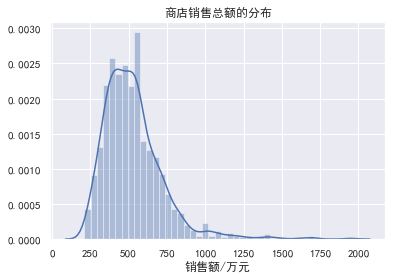

In [13]:
df1=train.groupby('Store')['Sales'].sum().div(10000)
sns.distplot(df1)
plt.xlabel('销售额/万元')
plt.title('商店销售总额的分布')

Text(0.5, 1.0, '一周中每天平均销售额')

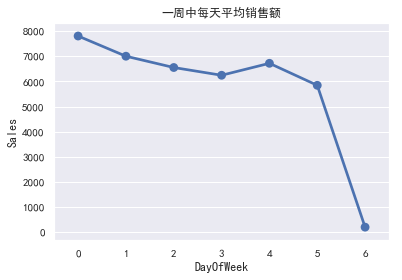

In [14]:
#reset_index()：重新生成 DataFrame or Series 
df2=train.groupby('DayOfWeek')['Sales'].mean().reset_index()
sns.pointplot(data=df2, x='DayOfWeek', y='Sales')
plt.title('一周中每天平均销售额')

Text(0.5, 1.0, '商店每月平均销售额情况')

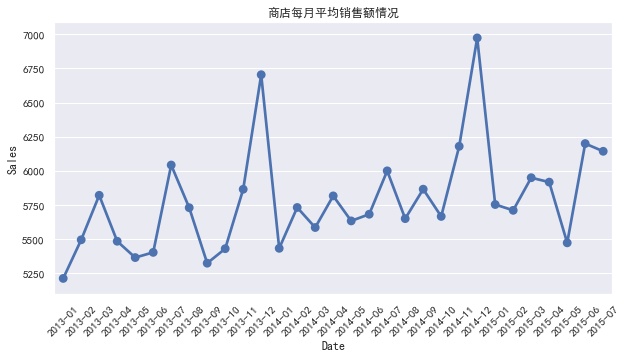

In [15]:
#resample:对Date日期截取到月，然后根据这个截取字段 进行统计。（M:表示截取到月， kind='period'：表示Date是日期字段）
df4=train.groupby('Date')['Sales'].mean().resample('M', kind='period').mean().reset_index()
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)

sns.pointplot(data=df4, x='Date', y='Sales', ax=ax)
plt.xticks(rotation=45)
ax.set_title('商店每月平均销售额情况')

[Text(0.5, 1.0, '促销天和非促销天销售额分布情况')]

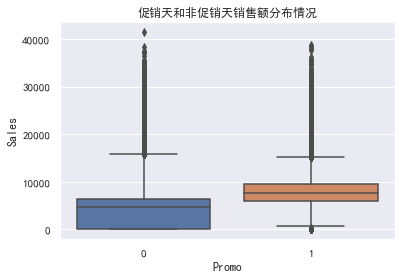

In [16]:
#对比促销天和非促销天销售分布情况
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
sns.boxplot(y='Sales',x='Promo',data=train,ax=ax)
ax.set(**{'title':'促销天和非促销天销售额分布情况'})

[Text(0.5, 1.0, '非国家假日销售分布')]

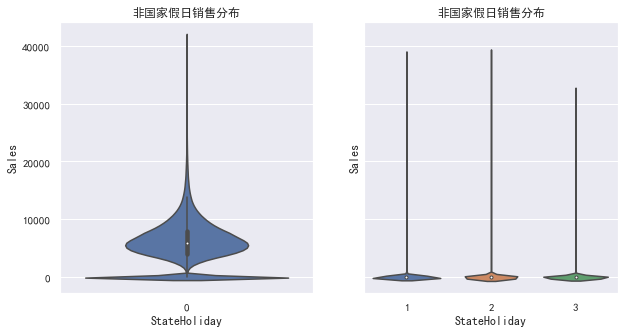

In [17]:
#对比stateholiday销售分布情况
fig,ax=plt.subplots(1,2,sharey=True,figsize=(10,5))

#不是国家节假日的销售分布
sns.violinplot(y='Sales',x='StateHoliday',data=train[train.StateHoliday==0],ax=ax[0])
ax[0].set(**{'title':'非国家假日销售分布'})

#不是国家节假日的销售分布
sns.violinplot(y='Sales',x='StateHoliday',data=train[train.StateHoliday!=0],ax=ax[1])
ax[1].set(**{'title':'非国家假日销售分布'})


[Text(0.5, 1.0, '学校假期销售分布')]

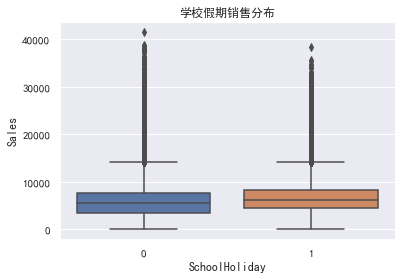

In [18]:
#对比SchoolHoliday销售分布情况
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

#SchoolHoliday的销售分布
sns.boxplot(y='Sales',x='SchoolHoliday',data=train)
ax.set(**{'title':'学校假期销售分布'})

# 删除无用字段

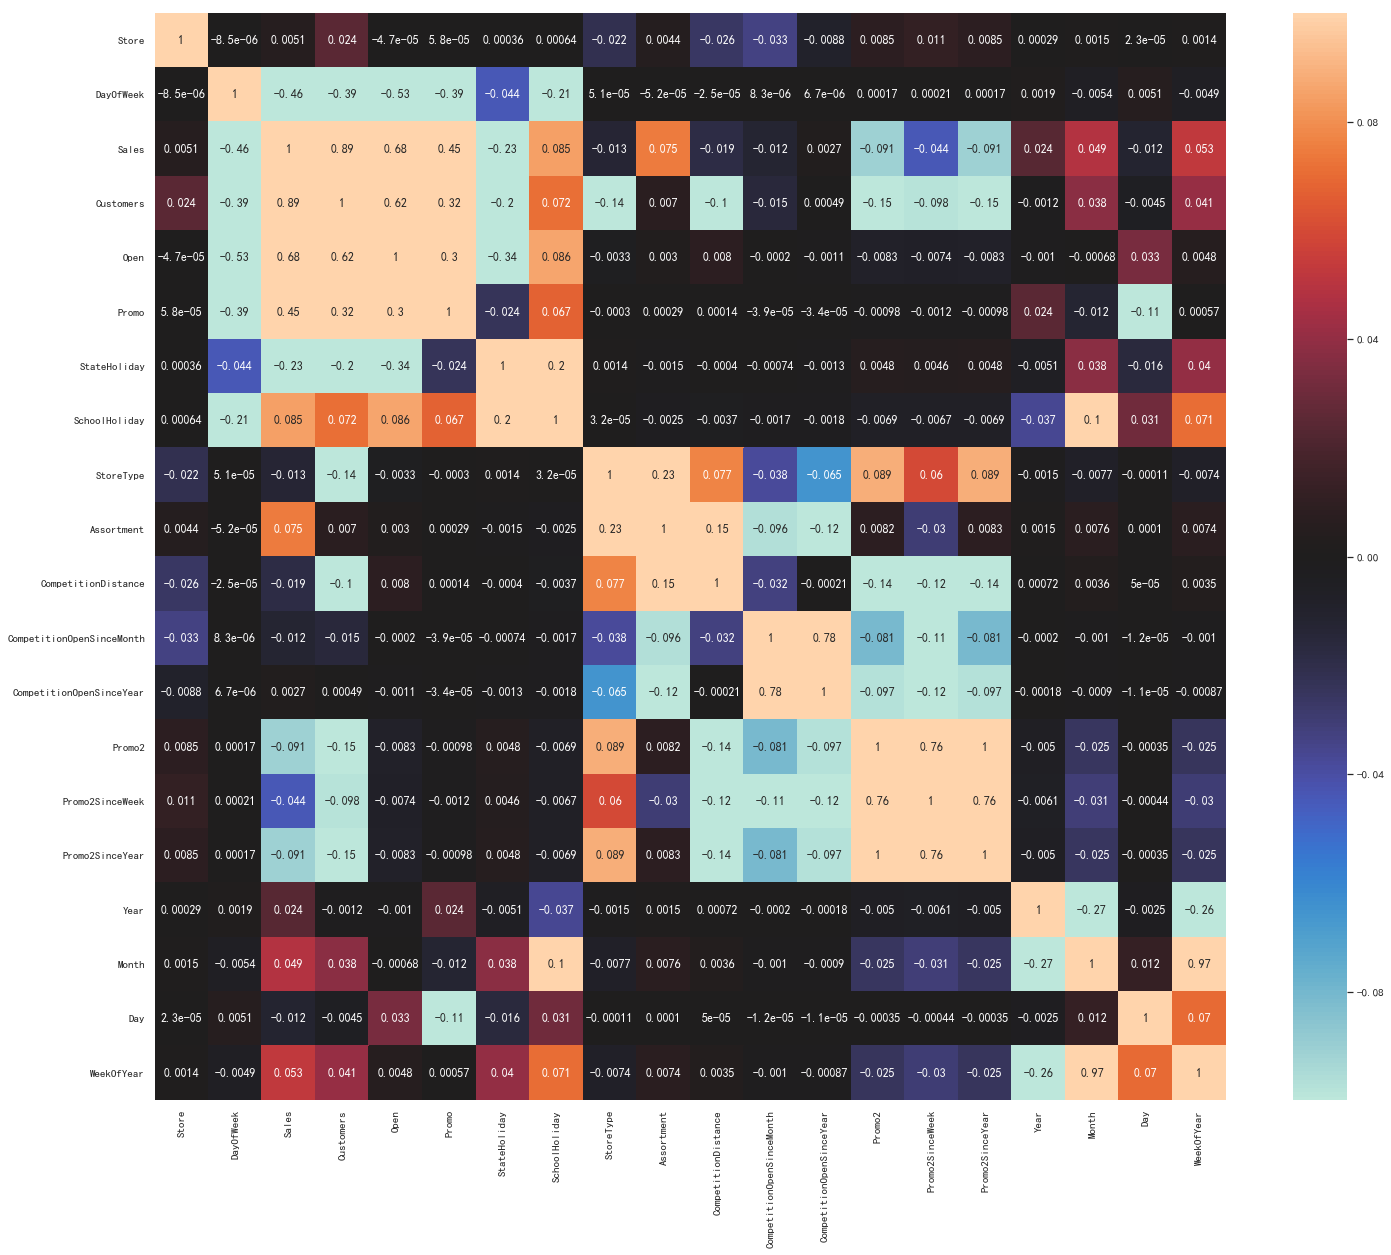

In [19]:
#分析训练数据集中特征相关性以及特征与'Sales'标签相关性
plt.subplots(figsize=(24,20))
sns.heatmap(train.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

# 分割验证数据

## 分割验证数据

In [20]:
#按照日期进行降序排序
train = train.sort_values(['Date'],ascending = False)

In [21]:
#最近的6周数据 作为验证数据
train_test = train[:6*7*1115]
train_train = train[6*7*1115:]

## 删除无用信息

In [22]:
#将销售额为0和店铺未开发的店铺从训练数据中剔除
train_test = train_test[train_test["Open"] != 0]
train_test = train_test[train_test["Sales"] > 0]

train_train = train_train[train_train["Open"] != 0]
train_train = train_train[train_train["Sales"] > 0]

In [23]:
#删掉训练和保留数据集中不需要的特征
train_test.drop(['Date','Customers','Open','PromoInterval'],axis=1,inplace =True)
train_train.drop(['Date','Customers','Open','PromoInterval'],axis=1,inplace =True)

#删掉测试集中对应的特征与训练集保持一致
xtest =test.drop(['Id','Date','Open','PromoInterval'],axis = 1)

## 提取标签

In [24]:
#拆分特征与标签，并将标签取对数处理
x_train = train_train.drop(['Sales'],axis=1 )
y_train = np.log1p(train_train.Sales)

x_train.head()

In [ ]:
y_train.head()

In [ ]:
#验证集
x_valid = train_test.drop(['Sales'],axis=1 )
y_valid = np.log1p(train_test.Sales)


# 定义评价函数

In [25]:
 #定义评价函数rmspe
def rmspe(y, yhat):
    return np.sqrt(np.mean((np.divide(np.subtract(y, yhat),y))**2))
    
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)


# 模型构建

In [26]:
#参数设定
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.02,                     #学习率
          "max_depth": 10,                 #树最大深度
          "subsample": 0.9,                #随机选取样本的比率
          "colsample_bytree": 0.7,         #随机选取特征的比率（构造树时） 
          "silent": 1,                     #只打印警告信息
          "seed": 78
          }
#每次训练数量
num_boost_round = 6
 
# 转换为训练数据与验证数据
dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)

#观察列表
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


#模型训练
print("Train a XGBoost model")
start = time()

gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

end = time()
print('Training time is {:2f} s.'.format(end-start))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train a XGBoost model
[0]	train-rmse:8.10329	valid-rmse:8.11016	train-rmspe:0.999837	valid-rmspe:0.999839
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.94154	valid-rmse:7.94896	train-rmspe:0.999779	valid-rmspe:0.999782
[2]	train-rmse:7.78308	valid-rmse:7.79046	train-rmspe:0.999712	valid-rmspe:0.999715
[3]	train-rmse:7.62777	valid-rmse:7.63515	train-rmspe:0.999635	valid-rmspe:0.999639
[4]	train-rmse:7.47554	valid-rmse:7.48309	train-rmspe:0.999547	valid-rmspe:0.999553
[5]	train-rmse:7.32641	valid-rmse:7.33369	train-rmspe:0.999447	valid-rmspe:0.999454
Training time is 4.110556 s.


In [27]:
#训练集验证
print("validating")

# 按序号排列数据，还原数据顺序
x_valid.sort_index(inplace=True) 
y_valid.sort_index(inplace=True) 

#预测数据
yhat_valid = gbm.predict(xgb.DMatrix(x_valid))

#验证得分
error = rmspe(np.expm1(y_valid), np.expm1(yhat_valid))
print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.999454


# 结果分析

- 从分析结果来看，我们的初始模型已经可以比较好的预测hold-out数据集的销售趋势，但是相对真实值，我们的模型的预测值整体要偏高一些。从对偏差数据分析来看，偏差最大的3个数据也是明显偏高。因此我们可以以hold-out数据集为标准对模型进行偏差校正。


所有商店均值比率(Sale/Prediction)：
商店编号为 0.16115619093341477 的平均比率
商店编号为 0.17308238083416244 的平均比率
商店编号为 0.15976486692644876 的平均比率


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceYear,Year,Month,Day,WeekOfYear,Sales,Prediction,Ratio,Error,Weight
827591,909,0,0,0,0,1,3,1680.0,0.0,0.0,...,2009.0,2015,6,22,26,10.634701,1.454667,0.136785,0.863215,7.310748
797963,876,0,0,0,0,1,1,21790.0,4.0,2005.0,...,2015.0,2015,7,6,28,10.215777,1.430188,0.139998,0.860002,7.142961
827590,909,1,0,0,0,1,3,1680.0,0.0,0.0,...,2009.0,2015,6,23,26,10.310252,1.458848,0.141495,0.858505,7.067392
797962,876,1,0,0,0,1,1,21790.0,4.0,2005.0,...,2015.0,2015,7,7,28,10.082805,1.433158,0.142139,0.857861,7.035376
766687,842,5,0,0,0,4,3,1200.0,11.0,2007.0,...,0.0,2015,6,20,25,10.084934,1.439149,0.142703,0.857297,7.007569
766652,842,5,0,0,0,4,3,1200.0,11.0,2007.0,...,0.0,2015,7,25,30,10.047242,1.439149,0.143238,0.856762,6.981378
264218,292,0,1,0,0,1,1,1100.0,6.0,2009.0,...,0.0,2015,6,29,27,10.280622,1.477179,0.143686,0.856314,6.959633
827593,909,5,0,0,0,1,3,1680.0,0.0,0.0,...,2009.0,2015,6,20,25,10.038150,1.442514,0.143703,0.856297,6.958790
743489,817,0,0,0,0,1,1,140.0,3.0,2006.0,...,0.0,2015,7,6,28,10.016995,1.440355,0.143791,0.856209,6.954532
743482,817,0,1,0,0,1,1,140.0,3.0,2006.0,...,0.0,2015,7,13,29,10.210200,1.470834,0.144055,0.855945,6.941773


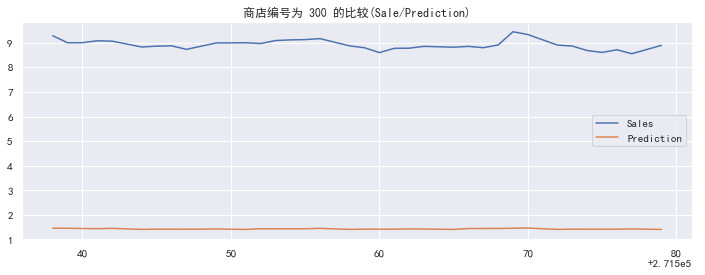

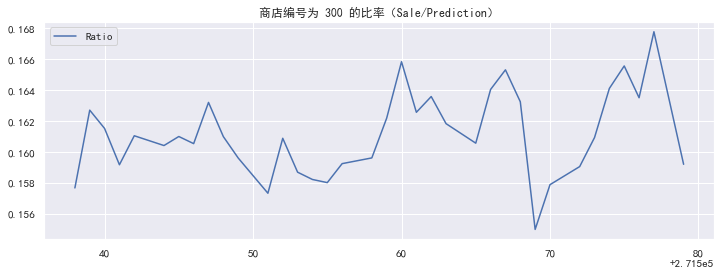

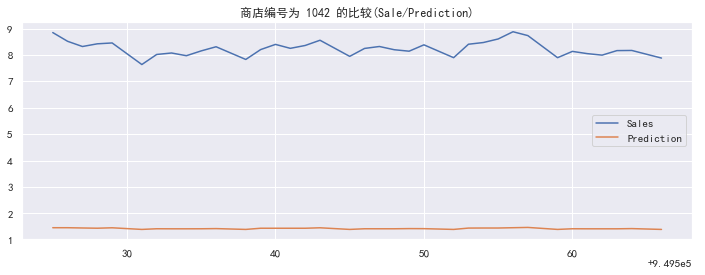

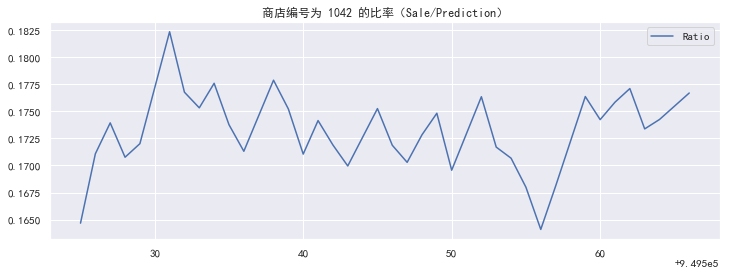

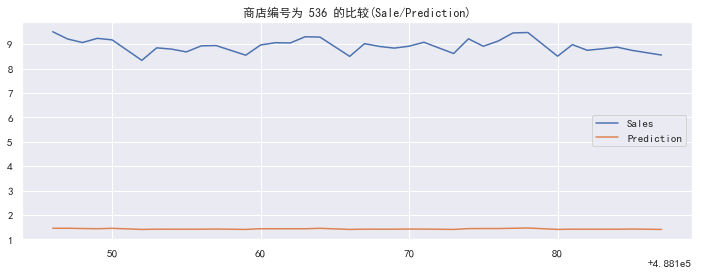

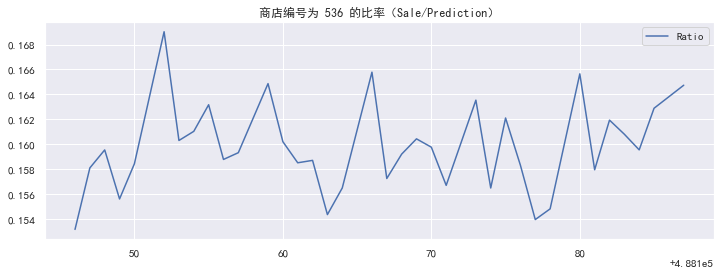

In [29]:
#构建保留数据集预测结果
res = pd.DataFrame(data = y_valid)
res['Prediction']=yhat_valid
# 通过index索引 将数据连接起来
res = pd.merge(x_valid, res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()
 

#分析保留数据集中任意三个店铺的预测结果
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
L=np.random.randint( low=1,high = 1115, size = 3 ) 
print('所有商店均值比率(Sale/Prediction)：'.format(res.Ratio.mean()))

for i in L:    
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    
    s1.plot(title = '商店编号为 {} 的比较(Sale/Prediction)'.format(i),figsize=(12,4))
    s2.plot(title = '商店编号为 {} 的比率（Sale/Prediction）'.format(i),figsize=(12,4))
    print('商店编号为 {} 的平均比率'.format(s2.Ratio.mean(),i))
 
 
#对误差降序排序，查看最大的是个误差
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]
 

# 模型优化

 - 当校正系数为0.995时，hold-out集的RMSPE得分最低：0.118889，相对于初始模型 0.125453得分有很大的提升。

 - 因为每个店铺都有自己的特点，而我们设计的模型对不同的店铺偏差并不完全相同，所以我们需要根据不同的店铺进行一个细致的校正。

In [2]:
#7.1偏差整体校正优化
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(y_valid), np.expm1(yhat_valid*w))
    S.append(error)
    print('RMSPE 权重{:.3f}  误差：{:.6f}'.format(w, error))
   
Score = pd.Series(S, index = W)
Score.plot()

BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

NameError: name 'rmspe' is not defined

In [33]:
#7.2细致校正：以不同的店铺分组进行细致校正，每个店铺分别计算可以取得最佳RMSPE得分的校正系数

#商店ID集合
Store_ID=range(1115)

#验证集与测试集权重集合
W_valid = []
W_test = []

#循环数据
for i in Store_ID:
    
    s1 = pd.DataFrame(res[res['Store']==i+1], columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    
    #获得最低rmspe分数
    Score = pd.Series(S, index = W1)
    BS = Score[Score.values == Score.values.min()]
    min_rmspe = np.array(BS.index.values)
    
    #将权重数量扩充到 与 验证数据 数量一致
    w_valid = min_rmspe.repeat(len(s1)).tolist()
    W_valid.extend(w_valid)
      
    w_test = min_rmspe.repeat(len(s2)).tolist()
    W_test.extend(w_test)
 
 
#计算校正后整体数据的RMSPE得分
yhat_new = yhat_valid*W_valid
error = rmspe(np.expm1(y_valid), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.999444


In [34]:
#用初始和校正后的模型对训练数据集进行预测
print("Make predictions on the test set")
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)
 
#初始模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_1.csv", index=False)
 
#整体校正模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*0.995)})
result.to_csv("Rossmann_submission_2.csv", index=False)
 
#细致校正模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*W_test)})
result.to_csv("Rossmann_submission_3.csv", index=False)


Make predictions on the test set


In [35]:
#7.2训练融合模型
print("Train an new ensemble XGBoost model")
start = time()

#训练次数
rounds = 10

#验证与测试矩阵
preds_valid = np.zeros((len(x_valid.index), rounds))
preds_test = np.zeros((len(test.index), rounds))

error_info =[]
for r in range(rounds):
    print('round {}:'.format(r+1))
    
    #模型参数
    params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": r+1
          }
    
    #模型训练
    num_boost_round = 6
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                    early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
   
    #模型预测
    yhat_valid = gbm.predict(xgb.DMatrix(x_valid))
    
    Store_ID=range(1115)
    
    #最佳验证集与测试集权重集合
    W_valid=[]
    W_test=[]
    
    for i in Store_ID:
        s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
        s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
        
        W1=[(0.990+(i/1000)) for i in range(20)]
        S =[]       
        for w in W1:
            error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
            S.append(error)
            
        Score = pd.Series(S,index=W1)
        BS = Score[Score.values == Score.values.min()]              
        min_rmspe = np.array(BS.index.values)
        
        #将权重数量扩充到 与 验证数据 数量一致
        w_valid = min_rmspe.repeat(len(s1)).tolist()
        W_valid.extend(w_valid)

        w_test = min_rmspe.repeat(len(s2)).tolist()
        W_test.extend(w_test)    

    
    preds_valid[:, r] = yhat_valid*W_valid
    preds_test[:, r] = gbm.predict(xgb.DMatrix(xtest))*W_test
    print('round {} end'.format(r+1))
    
end = time()
time_elapsed = end-start
print('Training is end')
print('Training time is {} h.'.format(time_elapsed/3600))   

Train an new ensemble XGBoost model
round 1:
[0]	train-rmse:8.02081	valid-rmse:8.02787	train-rmspe:0.999808	valid-rmspe:0.999811
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78064	valid-rmse:7.78825	train-rmspe:0.999711	valid-rmspe:0.999714
[2]	train-rmse:7.54779	valid-rmse:7.55422	train-rmspe:0.99959	valid-rmspe:0.999595
[3]	train-rmse:7.32192	valid-rmse:7.32827	train-rmspe:0.999443	valid-rmspe:0.99945
[4]	train-rmse:7.10282	valid-rmse:7.10902	train-rmspe:0.999266	valid-rmspe:0.999274
[5]	train-rmse:6.89029	valid-rmse:6.89619	train-rmspe:0.999053	valid-rmspe:0.999063
round 1 end
round 2:
[0]	train-rmse:8.02076	valid-rmse:8.0281	train-rmspe:0.999809	valid-rmspe:0.999811
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78061	valid-rmse:7.78832	train-rmspe

In [36]:
# #分析不同模型的相关性
# preds = pd.DataFrame(preds_valid)
# sns.pairplot(preds)
 
 
#模型融合可以采用简单平均或者加权重的方法进行融合。从上图来看，这10个模型相关性很高，差别不大，所以权重融合我们只考虑训练中单独模型在hold-out模型中的得分情况分配权重。
#模型融合在hold-out数据集上的表现
 
#简单平均融合
print ('Validating')
 
bagged_ho_preds1 = preds_valid.mean(axis = 1)
error1 = rmspe(np.expm1(y_valid), np.expm1(bagged_ho_preds1))
print('RMSPE for mean: {:.6f}'.format(error1))

#均值融合
print("Make predictions on the test set")
bagged_preds = preds_test.mean(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("Rossmann_submission_4.csv", index=False)

Validating
RMSPE for mean: 0.999047
Make predictions on the test set


# 模型特征重要性及最佳模型结果分析

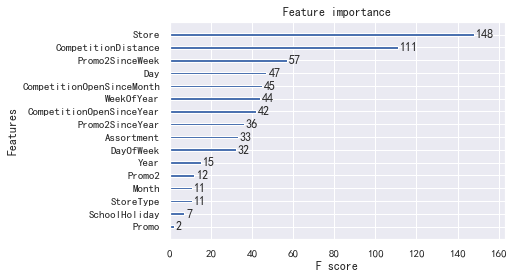

In [37]:
#模型特征重要性
xgb.plot_importance(gbm)

In [38]:
gbm.save_model('data/model/xgb.model')